In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from  matplotlib.patches import Polygon
from IPython.display import Image
import imageio.v2
import csv

import tqdm as tqdm
import jax 
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_debug_nans", False)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from iLQR import iLQR, Path



In [33]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

Update from  188.21582  to  187.80138 reg:  1.0 alpha: 1.000 2.936
Update from  187.80138  to  163.80869 reg:  0.5 alpha: 0.100 2.942
Update from  163.80869  to  131.84755 reg:  0.25 alpha: 1.000 2.945
Update from  131.84755  to  125.74664 reg:  0.125 alpha: 0.100 2.951
Update from  125.74664  to  122.06799 reg:  0.0625 alpha: 0.100 2.957
Update from  122.06799  to  119.6273 reg:  0.03125 alpha: 0.100 2.962
Update from  119.6273  to  115.25689 reg:  0.015625 alpha: 0.100 2.967
Update from  115.25689  to  103.01703 reg:  0.0078125 alpha: 1.000 2.972
Update from  103.01703  to  99.6135 reg:  0.00390625 alpha: 1.000 2.976
Update from  99.6135  to  98.99544 reg:  0.001953125 alpha: 1.000 2.980
Update from  98.99544  to  98.90854 reg:  0.001 alpha: 1.000 2.983
Update from  98.90854  to  98.90723 reg:  0.001 alpha: 1.000 2.987
Update from  98.90723  to  98.90713 reg:  0.001 alpha: 1.000 2.990
Update from  557.74634  to  518.1405 reg:  25.0 alpha: 0.100 0.028
Update from  518.1405  to  507.72

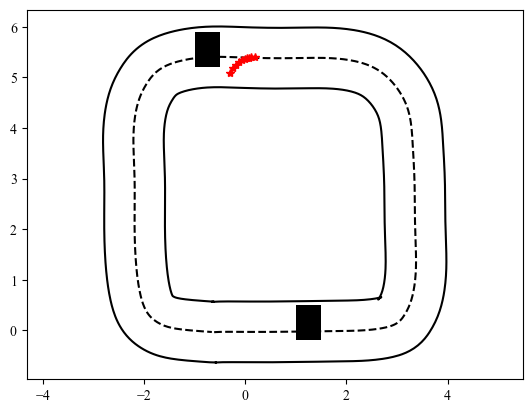

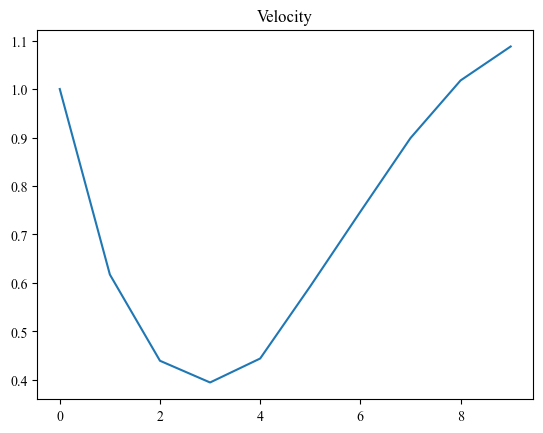

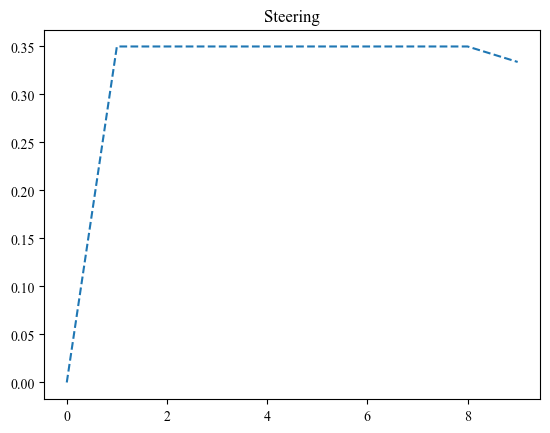

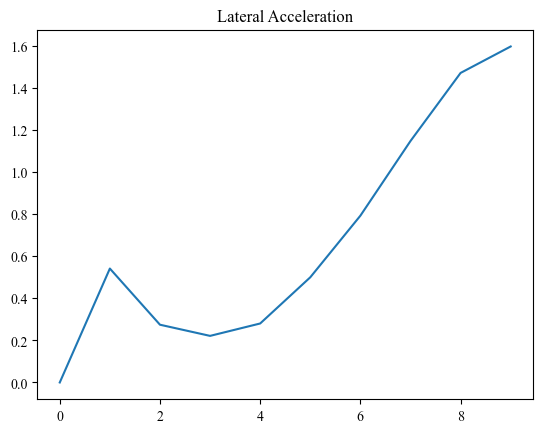

In [231]:
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)
config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR()#config_file)
# # make some obstacles
# obs1 = np.array([[-1, -1, -0, -0], [5.2, 6.0, 6.0, 5.2]]).T
obs1 = np.array([[-1, -1, -0.5, -0.5], [5.2, 5.9, 5.9, 5.2]]).T
obs2 = np.array([[1, 1, 1.5, 1.5], [-0.2, 0.5, 0.5, -0.2]]).T
obs_list = [[obs1 for _ in range(10)]]#, [obs2 for _ in range(10)]]
solver.update_obstacles(obs_list)
solver.update_path(path)

x_cur = np.array([0.2, 5.4, 1, 3.14, 0])
plan = solver.plan(x_cur)

path.plot_track()
path.plot_track_center()
plt.plot(plan['states'][0, :], plan['states'][1, :], 'r-*', linewidth=2)

p = Polygon(obs1, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

p = Polygon(obs2, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

print(plan['status'])

plt.figure()
a = plan['states'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['states'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['states'][2, :]**2 / 0.257 * np.tan(plan['states'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')

print(plan['t_process'])


Update from  188.21582  to  187.80138 reg:  1.0 alpha: 1.000 2.955
Update from  187.80138  to  163.80869 reg:  0.5 alpha: 0.100 2.960
Update from  163.80869  to  131.84755 reg:  0.25 alpha: 1.000 2.964
Update from  131.84755  to  125.74664 reg:  0.125 alpha: 0.100 2.969
Update from  125.74664  to  122.06799 reg:  0.0625 alpha: 0.100 2.974
Update from  122.06799  to  119.6273 reg:  0.03125 alpha: 0.100 2.979
Update from  119.6273  to  115.25689 reg:  0.015625 alpha: 0.100 2.985
Update from  115.25689  to  103.01703 reg:  0.0078125 alpha: 1.000 2.988
Update from  103.01703  to  99.6135 reg:  0.00390625 alpha: 1.000 2.991
Update from  99.6135  to  98.99544 reg:  0.001953125 alpha: 1.000 2.995
Update from  98.99544  to  98.90854 reg:  0.001 alpha: 1.000 2.998


iLQR takes : 0.11 sec']:   0%|          | 0/100 [00:00<?, ?it/s]

Update from  90.34918  to  72.688675 reg:  3125.0 alpha: 1.000 0.079
Update from  72.688675  to  62.12358 reg:  1562.5 alpha: 1.000 0.085
Update from  62.12358  to  57.368973 reg:  781.25 alpha: 1.000 0.091
Update from  57.368973  to  54.20983 reg:  390.625 alpha: 1.000 0.098
Update from  54.20983  to  50.342506 reg:  195.3125 alpha: 1.000 0.104
Update from  50.342506  to  50.319733 reg:  97.65625 alpha: 1.000 0.110


iLQR takes : 0.08 sec']:   1%|          | 1/100 [00:00<00:26,  3.73it/s]

Update from  65.02818  to  60.71517 reg:  1.0 alpha: 0.100 0.015
Update from  60.71517  to  56.882706 reg:  0.5 alpha: 1.000 0.022
Update from  56.882706  to  56.771873 reg:  31.25 alpha: 0.010 0.074
Update from  56.771873  to  56.75731 reg:  15.625 alpha: 0.100 0.084


iLQR takes : 0.06 sec']:   2%|▏         | 2/100 [00:00<00:25,  3.85it/s]

Update from  71.16217  to  71.007675 reg:  1.0 alpha: 0.100 0.016
Update from  71.007675  to  70.88539 reg:  0.5 alpha: 0.100 0.028
Update from  70.88539  to  70.73982 reg:  0.25 alpha: 0.100 0.039
Update from  70.73982  to  70.635025 reg:  0.125 alpha: 0.100 0.049
Update from  70.635025  to  70.55155 reg:  0.0625 alpha: 0.100 0.059


iLQR takes : 0.03 sec']:   4%|▍         | 4/100 [00:00<00:22,  4.36it/s]

Update from  88.355034  to  83.99603 reg:  1.0 alpha: 0.100 0.016
Update from  83.99603  to  83.98938 reg:  0.5 alpha: 0.010 0.032


iLQR takes : 0.10 sec']:   4%|▍         | 4/100 [00:01<00:22,  4.36it/s]

Update from  98.34898  to  90.62932 reg:  125.0 alpha: 1.000 0.051
Update from  90.62932  to  90.5206 reg:  62.5 alpha: 0.100 0.062
Update from  90.5206  to  81.03743 reg:  156.25 alpha: 1.000 0.080
Update from  81.03743  to  80.656784 reg:  78.125 alpha: 0.100 0.091
Update from  80.656784  to  80.629265 reg:  39.0625 alpha: 0.100 0.101


iLQR takes : 0.02 sec']:   6%|▌         | 6/100 [00:01<00:21,  4.39it/s]

Update from  84.35989  to  84.34508 reg:  1.0 alpha: 0.010 0.021
Update from  94.39687  to  90.01958 reg:  25.0 alpha: 0.100 0.041
Update from  90.01958  to  86.334305 reg:  12.5 alpha: 0.100 0.051
Update from  86.334305  to  82.27577 reg:  6.25 alpha: 0.100 0.062
Update from  82.27577  to  79.23245 reg:  3.125 alpha: 0.100 0.073
Update from  79.23245  to  78.72853 reg:  1.5625 alpha: 0.010 0.088
Update from  78.72853  to  78.34129 reg:  0.78125 alpha: 0.010 0.103
Update from  78.34129  to  78.16461 reg:  0.390625 alpha: 0.010 0.117
Update from  78.16461  to  76.15628 reg:  0.1953125 alpha: 0.100 0.128
Update from  76.15628  to  74.930695 reg:  0.09765625 alpha: 0.010 0.142
Update from  74.930695  to  73.272354 reg:  0.048828125 alpha: 0.100 0.153
Update from  73.272354  to  71.98203 reg:  0.0244140625 alpha: 0.100 0.163
Update from  71.98203  to  71.129715 reg:  0.01220703125 alpha: 0.100 0.173
Update from  71.129715  to  70.51898 reg:  0.006103515625 alpha: 0.100 0.183
Update from  7

iLQR takes : 0.28 sec']:   7%|▋         | 7/100 [00:01<00:28,  3.30it/s]

Update from  70.326126  to  70.154854 reg:  23.84185791015625 alpha: 0.100 0.273
Update from  70.154854  to  70.112305 reg:  11.920928955078125 alpha: 0.100 0.284
Update from  65.492966  to  64.41768 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.01 sec']:   8%|▊         | 8/100 [00:02<00:25,  3.68it/s]

Update from  64.41768  to  64.28282 reg:  0.5 alpha: 0.100 0.023
Update from  64.28282  to  64.20184 reg:  0.25 alpha: 0.100 0.034
Update from  57.315773  to  57.21737 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.01 sec']:  10%|█         | 10/100 [00:02<00:20,  4.32it/s]

Update from  46.579144  to  46.46444 reg:  1.0 alpha: 1.000 0.012
Update from  46.46444  to  46.463455 reg:  0.5 alpha: 1.000 0.019
Update from  35.072372  to  35.06917 reg:  1.0 alpha: 1.000 0.012


iLQR takes : 0.03 sec']:  12%|█▏        | 12/100 [00:02<00:18,  4.66it/s]

Update from  22.711384  to  22.12661 reg:  1.0 alpha: 1.000 0.012
Update from  22.12661  to  22.00787 reg:  0.5 alpha: 1.000 0.019
Update from  22.00787  to  22.007534 reg:  0.25 alpha: 1.000 0.025


iLQR takes : 0.02 sec']:  13%|█▎        | 13/100 [00:03<00:18,  4.78it/s]

Update from  9.010822  to  7.795572 reg:  1.0 alpha: 1.000 0.012
Update from  7.795572  to  7.7937527 reg:  0.5 alpha: 1.000 0.018
Update from  1.7789242  to  1.1481943 reg:  1.0 alpha: 1.000 0.012


iLQR takes : 0.01 sec']:  14%|█▍        | 14/100 [00:03<00:17,  4.88it/s]

Update from  1.1481943  to  1.147116 reg:  0.5 alpha: 1.000 0.021
Update from  -0.3331791  to  -0.3845213 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  16%|█▌        | 16/100 [00:03<00:16,  5.02it/s]

Update from  -1.3864627  to  -1.3918492 reg:  1.0 alpha: 0.100 0.017
Update from  -2.0212789  to  -2.1837974 reg:  1.0 alpha: 1.000 0.011
Update from  -2.1837974  to  -2.184147 reg:  0.5 alpha: 1.000 0.018


iLQR takes : 0.01 sec']:  18%|█▊        | 18/100 [00:04<00:20,  3.98it/s]

Update from  -3.066006  to  -3.0975823 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  19%|█▉        | 19/100 [00:04<00:19,  4.21it/s]

Update from  -4.132807  to  -4.1339693 reg:  1.0 alpha: 0.010 0.023
Update from  -4.278689  to  -4.7883844 reg:  1.0 alpha: 1.000 0.012


iLQR takes : 0.02 sec']:  20%|██        | 20/100 [00:04<00:18,  4.42it/s]

Update from  -4.7883844  to  -4.7884703 reg:  0.5 alpha: 0.100 0.023
Update from  -4.572225  to  -4.9673657 reg:  1.0 alpha: 1.000 0.011
Update from  -4.9673657  to  -4.9674177 reg:  0.5 alpha: 0.100 0.023


iLQR takes : 0.02 sec']:  22%|██▏       | 22/100 [00:05<00:16,  4.73it/s]

Update from  -4.3747444  to  -4.8791146 reg:  1.0 alpha: 1.000 0.012
Update from  -4.8791146  to  -4.8792167 reg:  0.5 alpha: 0.100 0.023
Update from  -4.4247527  to  -4.5770726 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  23%|██▎       | 23/100 [00:05<00:16,  4.76it/s]

Update from  -4.5770726  to  -4.6550655 reg:  0.5 alpha: 1.000 0.019
Update from  -4.046717  to  -4.3465047 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  24%|██▍       | 24/100 [00:05<00:15,  4.87it/s]

Update from  -4.3465047  to  -4.357016 reg:  0.5 alpha: 1.000 0.019
Update from  -3.0267131  to  -3.5947526 reg:  1.0 alpha: 1.000 0.011
Update from  -3.5947526  to  -3.5992277 reg:  0.5 alpha: 1.000 0.020


iLQR takes : 0.04 sec']:  26%|██▌       | 26/100 [00:05<00:15,  4.86it/s]

Update from  2.3663425  to  -0.32437158 reg:  1.0 alpha: 1.000 0.012
Update from  -0.32437158  to  -0.5150361 reg:  0.5 alpha: 0.010 0.029
Update from  -0.5150361  to  -0.5874181 reg:  0.25 alpha: 0.100 0.041


iLQR takes : 0.13 sec']:  26%|██▌       | 26/100 [00:06<00:15,  4.86it/s]

Update from  25.953037  to  14.695229 reg:  1.0 alpha: 0.100 0.017
Update from  14.695229  to  7.7092323 reg:  0.5 alpha: 1.000 0.024
Update from  7.7092323  to  6.7658854 reg:  0.25 alpha: 1.000 0.034
Update from  6.7658854  to  6.67719 reg:  1953.125 alpha: 1.000 0.126


iLQR takes : 0.02 sec']:  28%|██▊       | 28/100 [00:06<00:16,  4.50it/s]

Update from  20.158566  to  14.809221 reg:  1.0 alpha: 1.000 0.011
Update from  14.809221  to  14.760567 reg:  0.5 alpha: 1.000 0.019
Update from  23.906166  to  23.885448 reg:  1.0 alpha: 0.100 0.016


iLQR takes : 0.10 sec']:  29%|██▉       | 29/100 [00:06<00:15,  4.70it/s]

Update from  40.621918  to  40.058105 reg:  1.0 alpha: 1.000 0.011
Update from  40.058105  to  38.760544 reg:  62.5 alpha: 0.100 0.060
Update from  38.760544  to  37.803413 reg:  156.25 alpha: 1.000 0.079
Update from  37.803413  to  37.49571 reg:  78.125 alpha: 1.000 0.085
Update from  37.49571  to  37.49129 reg:  39.0625 alpha: 0.010 0.099


iLQR takes : 0.12 sec']:  30%|███       | 30/100 [00:06<00:16,  4.33it/s]

Update from  67.384514  to  56.694595 reg:  1.0 alpha: 0.100 0.016
Update from  56.694595  to  51.16234 reg:  0.5 alpha: 0.100 0.027
Update from  51.16234  to  50.52867 reg:  156.25 alpha: 0.100 0.087
Update from  50.52867  to  50.224976 reg:  78.125 alpha: 0.010 0.101
Update from  50.224976  to  50.21996 reg:  39.0625 alpha: 0.010 0.115


iLQR takes : 0.12 sec']:  31%|███       | 31/100 [00:07<00:17,  4.03it/s]

Update from  77.242485  to  69.68586 reg:  1.0 alpha: 0.100 0.016
Update from  69.68586  to  66.9601 reg:  0.5 alpha: 0.100 0.033
Update from  66.9601  to  61.07502 reg:  156.25 alpha: 1.000 0.093
Update from  61.07502  to  60.25374 reg:  78.125 alpha: 0.010 0.107
Update from  60.25374  to  60.112434 reg:  39.0625 alpha: 0.010 0.121
Update from  60.112434  to  57.85065 reg:  97.65625 alpha: 0.100 0.143
Update from  57.85065  to  53.386745 reg:  244.140625 alpha: 1.000 0.161
Update from  53.386745  to  52.37112 reg:  122.0703125 alpha: 0.100 0.171
Update from  52.37112  to  52.01652 reg:  61.03515625 alpha: 0.100 0.182
Update from  52.01652  to  49.317165 reg:  152.587890625 alpha: 1.000 0.200
Update from  49.317165  to  44.51052 reg:  76.2939453125 alpha: 1.000 0.206
Update from  44.51052  to  44.395958 reg:  38.14697265625 alpha: 0.100 0.216


iLQR takes : 0.27 sec']:  32%|███▏      | 32/100 [00:07<00:20,  3.28it/s]

Update from  44.395958  to  44.00127 reg:  476.837158203125 alpha: 1.000 0.248
Update from  44.00127  to  43.484898 reg:  238.4185791015625 alpha: 1.000 0.255
Update from  43.484898  to  43.450005 reg:  119.20928955078125 alpha: 0.100 0.265


iLQR takes : 0.02 sec']:  33%|███▎      | 33/100 [00:07<00:18,  3.70it/s]

Update from  43.41001  to  43.36114 reg:  1.0 alpha: 0.100 0.016
Update from  48.065586  to  47.89583 reg:  1.0 alpha: 0.100 0.015
Update from  47.89583  to  47.76683 reg:  0.5 alpha: 0.100 0.026


iLQR takes : 0.04 sec']:  34%|███▍      | 34/100 [00:08<00:16,  3.90it/s]

Update from  47.76683  to  47.681755 reg:  0.25 alpha: 0.100 0.036


iLQR takes : 0.07 sec']:  35%|███▌      | 35/100 [00:08<00:16,  3.98it/s]

Update from  66.04216  to  64.96482 reg:  25.0 alpha: 0.010 0.045
Update from  64.96482  to  60.021004 reg:  12.5 alpha: 1.000 0.052
Update from  60.021004  to  60.01643 reg:  6.25 alpha: 0.010 0.067


iLQR takes : 0.03 sec']:  36%|███▌      | 36/100 [00:08<00:15,  4.18it/s]

Update from  78.935776  to  76.64635 reg:  1.0 alpha: 1.000 0.012
Update from  76.64635  to  76.47037 reg:  0.5 alpha: 0.100 0.023
Update from  76.47037  to  76.44141 reg:  0.25 alpha: 0.100 0.034


iLQR takes : 0.11 sec']:  36%|███▌      | 36/100 [00:08<00:15,  4.18it/s]

Update from  117.92747  to  100.00332 reg:  1.0 alpha: 0.100 0.016
Update from  100.00332  to  96.78142 reg:  62.5 alpha: 0.100 0.066
Update from  96.78142  to  96.359795 reg:  156.25 alpha: 0.100 0.088
Update from  96.359795  to  96.171814 reg:  78.125 alpha: 0.100 0.098
Update from  96.171814  to  95.692276 reg:  39.0625 alpha: 1.000 0.105
Update from  95.692276  to  95.639114 reg:  19.53125 alpha: 1.000 0.111


iLQR takes : 0.13 sec']:  37%|███▋      | 37/100 [00:08<00:16,  3.88it/s]

Update from  137.02292  to  121.543106 reg:  1.0 alpha: 0.100 0.019
Update from  121.543106  to  120.42274 reg:  0.5 alpha: 0.100 0.030
Update from  120.42274  to  116.226105 reg:  781.25 alpha: 1.000 0.105
Update from  116.226105  to  115.52701 reg:  390.625 alpha: 1.000 0.112
Update from  115.52701  to  114.446434 reg:  195.3125 alpha: 1.000 0.118
Update from  114.446434  to  113.58822 reg:  97.65625 alpha: 1.000 0.125
Update from  113.58822  to  113.58769 reg:  48.828125 alpha: 1.000 0.131


iLQR takes : 0.14 sec']:  38%|███▊      | 38/100 [00:09<00:17,  3.61it/s]

Update from  157.26346  to  143.10245 reg:  1.0 alpha: 1.000 0.012
Update from  143.10245  to  140.99586 reg:  0.5 alpha: 0.010 0.030
Update from  140.99586  to  138.68895 reg:  0.25 alpha: 0.010 0.047
Update from  138.68895  to  136.56909 reg:  0.125 alpha: 0.010 0.062
Update from  136.56909  to  136.55902 reg:  976.5625 alpha: 0.100 0.144


iLQR takes : 0.15 sec']:  39%|███▉      | 39/100 [00:09<00:18,  3.39it/s]

Update from  179.25688  to  175.94759 reg:  1.0 alpha: 1.000 0.012
Update from  175.94759  to  171.72438 reg:  0.5 alpha: 0.100 0.024
Update from  171.72438  to  170.74846 reg:  156.25 alpha: 0.100 0.083
Update from  170.74846  to  168.95648 reg:  78.125 alpha: 0.100 0.094
Update from  168.95648  to  168.55792 reg:  39.0625 alpha: 0.100 0.104
Update from  168.55792  to  167.29858 reg:  19.53125 alpha: 0.100 0.114
Update from  167.29858  to  167.20888 reg:  244.140625 alpha: 0.010 0.154


iLQR takes : 0.16 sec']:  40%|████      | 40/100 [00:09<00:18,  3.21it/s]

Update from  211.47417  to  207.33492 reg:  1.0 alpha: 1.000 0.011
Update from  207.33492  to  204.49187 reg:  0.5 alpha: 0.100 0.023
Update from  204.49187  to  203.73398 reg:  0.25 alpha: 0.100 0.034
Update from  203.73398  to  202.32541 reg:  78.125 alpha: 0.010 0.096
Update from  202.32541  to  200.64812 reg:  195.3125 alpha: 0.100 0.117
Update from  200.64812  to  200.11461 reg:  97.65625 alpha: 0.100 0.128
Update from  200.11461  to  199.92162 reg:  48.828125 alpha: 0.100 0.138
Update from  199.92162  to  199.80746 reg:  24.4140625 alpha: 0.100 0.148
Update from  199.80746  to  199.7536 reg:  12.20703125 alpha: 0.100 0.158


iLQR takes : 0.10 sec']:  41%|████      | 41/100 [00:10<00:22,  2.58it/s]

Update from  235.27403  to  231.2033 reg:  1.0 alpha: 1.000 0.011
Update from  231.2033  to  227.91376 reg:  0.5 alpha: 0.100 0.022
Update from  227.91376  to  227.69135 reg:  0.25 alpha: 0.010 0.038
Update from  227.69135  to  227.4891 reg:  0.125 alpha: 0.010 0.052
Update from  227.4891  to  227.31609 reg:  0.0625 alpha: 0.010 0.067
Update from  227.31609  to  227.18059 reg:  0.03125 alpha: 0.010 0.082
Update from  227.18059  to  227.10912 reg:  0.015625 alpha: 0.010 0.098


iLQR takes : 0.10 sec']:  42%|████▏     | 42/100 [00:10<00:20,  2.82it/s]

Update from  259.28415  to  256.81525 reg:  1.0 alpha: 1.000 0.011
Update from  256.81525  to  255.7244 reg:  0.5 alpha: 0.100 0.022
Update from  255.7244  to  254.23868 reg:  0.25 alpha: 0.100 0.034
Update from  254.23868  to  252.67352 reg:  0.125 alpha: 0.100 0.045
Update from  252.67352  to  252.51588 reg:  0.0625 alpha: 0.010 0.059
Update from  252.51588  to  252.35892 reg:  0.03125 alpha: 0.010 0.074
Update from  252.35892  to  252.24847 reg:  0.015625 alpha: 0.010 0.089


iLQR takes : 0.17 sec']:  43%|████▎     | 43/100 [00:11<00:20,  2.72it/s]

Update from  280.40213  to  277.9797 reg:  1.0 alpha: 1.000 0.011
Update from  277.9797  to  276.85175 reg:  0.5 alpha: 0.100 0.022
Update from  276.85175  to  275.58438 reg:  0.25 alpha: 0.100 0.033
Update from  275.58438  to  274.47577 reg:  0.125 alpha: 0.100 0.044
Update from  274.47577  to  273.88223 reg:  0.0625 alpha: 0.100 0.054


iLQR takes : 0.16 sec']:  44%|████▍     | 44/100 [00:11<00:20,  2.75it/s]

Update from  299.021  to  296.32895 reg:  1.0 alpha: 1.000 0.012
Update from  296.32895  to  295.1744 reg:  0.5 alpha: 0.100 0.024
Update from  295.1744  to  293.9424 reg:  0.25 alpha: 0.100 0.037
Update from  293.9424  to  292.97174 reg:  0.125 alpha: 0.100 0.047
Update from  292.97174  to  292.9714 reg:  24414.0625 alpha: 0.010 0.157


iLQR takes : 0.17 sec']:  45%|████▌     | 45/100 [00:11<00:19,  2.81it/s]

Update from  317.40668  to  314.49747 reg:  1.0 alpha: 1.000 0.011
Update from  314.49747  to  313.34412 reg:  0.5 alpha: 0.100 0.024
Update from  313.34412  to  312.12308 reg:  0.25 alpha: 0.100 0.035
Update from  312.12308  to  311.00754 reg:  0.125 alpha: 0.100 0.046
Update from  311.00754  to  310.81952 reg:  0.0625 alpha: 0.100 0.056
Update from  310.81952  to  310.8194 reg:  12207.03125 alpha: 0.010 0.166


iLQR takes : 0.12 sec']:  46%|████▌     | 46/100 [00:12<00:19,  2.83it/s]

Update from  331.8587  to  326.61102 reg:  1.0 alpha: 1.000 0.011
Update from  326.61102  to  326.43002 reg:  0.5 alpha: 0.100 0.024
Update from  326.43002  to  326.42987 reg:  19531.25 alpha: 0.010 0.122


iLQR takes : 0.11 sec']:  47%|████▋     | 47/100 [00:12<00:17,  2.97it/s]

Update from  346.02325  to  340.3445 reg:  1.0 alpha: 1.000 0.011
Update from  340.3445  to  340.34448 reg:  39062.5 alpha: 0.010 0.113


iLQR takes : 0.05 sec']:  48%|████▊     | 48/100 [00:12<00:16,  3.11it/s]

Update from  358.72556  to  352.4709 reg:  1.0 alpha: 1.000 0.011
Update from  352.4709  to  352.47046 reg:  12.5 alpha: 0.010 0.055


iLQR takes : 0.03 sec']:  50%|█████     | 50/100 [00:13<00:13,  3.74it/s]

Update from  369.93143  to  363.9318 reg:  1.0 alpha: 1.000 0.013
Update from  363.9318  to  362.46646 reg:  0.5 alpha: 0.100 0.025
Update from  362.46646  to  362.45984 reg:  0.25 alpha: 1.000 0.032


iLQR takes : 0.03 sec']:  51%|█████     | 51/100 [00:13<00:12,  4.04it/s]

Update from  377.1614  to  370.07733 reg:  1.0 alpha: 1.000 0.012
Update from  370.07733  to  369.91193 reg:  0.5 alpha: 1.000 0.019
Update from  369.91193  to  369.87302 reg:  0.25 alpha: 1.000 0.026
Update from  382.72055  to  375.39725 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  52%|█████▏    | 52/100 [00:13<00:11,  4.33it/s]

Update from  375.39725  to  375.35 reg:  0.5 alpha: 1.000 0.019
Update from  386.4145  to  379.18137 reg:  1.0 alpha: 1.000 0.011
Update from  379.18137  to  379.1341 reg:  0.5 alpha: 1.000 0.018


iLQR takes : 0.03 sec']:  54%|█████▍    | 54/100 [00:13<00:09,  4.69it/s]

Update from  389.60156  to  381.8582 reg:  1.0 alpha: 1.000 0.011
Update from  381.8582  to  381.58133 reg:  0.5 alpha: 1.000 0.018
Update from  381.58133  to  381.5225 reg:  0.25 alpha: 1.000 0.026
Update from  390.56613  to  383.13217 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  55%|█████▌    | 55/100 [00:14<00:09,  4.82it/s]

Update from  383.13217  to  383.06024 reg:  0.5 alpha: 1.000 0.019
Update from  392.28766  to  384.43878 reg:  1.0 alpha: 1.000 0.011
Update from  384.43878  to  383.90317 reg:  0.5 alpha: 1.000 0.018
Update from  383.90317  to  383.82605 reg:  0.25 alpha: 1.000 0.025


iLQR takes : 0.02 sec']:  57%|█████▋    | 57/100 [00:14<00:08,  4.97it/s]

Update from  391.8349  to  384.1958 reg:  1.0 alpha: 1.000 0.011
Update from  384.1958  to  384.1039 reg:  0.5 alpha: 1.000 0.018
Update from  392.74872  to  385.0104 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.04 sec']:  58%|█████▊    | 58/100 [00:14<00:08,  4.90it/s]

Update from  385.0104  to  384.13705 reg:  0.5 alpha: 0.100 0.022
Update from  384.13705  to  383.922 reg:  0.25 alpha: 1.000 0.029
Update from  383.922  to  383.8898 reg:  0.125 alpha: 1.000 0.036
Update from  391.46887  to  383.95322 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.02 sec']:  59%|█████▉    | 59/100 [00:14<00:08,  4.93it/s]

Update from  383.95322  to  383.88626 reg:  0.5 alpha: 0.100 0.024
Update from  389.42325  to  387.61053 reg:  1.0 alpha: 1.000 0.011
Update from  387.61053  to  386.13126 reg:  0.5 alpha: 0.100 0.022


iLQR takes : 0.08 sec']:  59%|█████▉    | 59/100 [00:14<00:08,  4.93it/s]

Update from  386.13126  to  384.9882 reg:  0.25 alpha: 0.100 0.033
Update from  384.9882  to  384.27518 reg:  0.125 alpha: 0.100 0.044
Update from  384.27518  to  383.881 reg:  0.0625 alpha: 0.100 0.055
Update from  383.881  to  383.69305 reg:  0.03125 alpha: 0.100 0.066
Update from  383.69305  to  383.62146 reg:  0.015625 alpha: 0.100 0.077


iLQR takes : 0.04 sec']:  61%|██████    | 61/100 [00:15<00:08,  4.63it/s]

Update from  388.40277  to  386.15454 reg:  1.0 alpha: 0.100 0.016
Update from  386.15454  to  384.08017 reg:  0.5 alpha: 0.100 0.028
Update from  384.08017  to  383.44647 reg:  0.25 alpha: 1.000 0.035
Update from  383.44647  to  383.41745 reg:  0.125 alpha: 1.000 0.042


iLQR takes : 0.02 sec']:  62%|██████▏   | 62/100 [00:15<00:08,  4.66it/s]

Update from  391.04196  to  383.48224 reg:  1.0 alpha: 1.000 0.012
Update from  383.48224  to  383.42007 reg:  0.5 alpha: 0.100 0.023


iLQR takes : 0.09 sec']:  62%|██████▏   | 62/100 [00:15<00:08,  4.66it/s]

Update from  389.05753  to  386.8935 reg:  1.0 alpha: 1.000 0.013
Update from  386.8935  to  385.49396 reg:  0.5 alpha: 0.100 0.025
Update from  385.49396  to  384.36877 reg:  0.25 alpha: 0.100 0.038
Update from  384.36877  to  383.7172 reg:  0.125 alpha: 0.100 0.050
Update from  383.7172  to  383.37402 reg:  0.0625 alpha: 0.100 0.062
Update from  383.37402  to  383.20782 reg:  0.03125 alpha: 0.100 0.074
Update from  383.20782  to  383.1297 reg:  0.015625 alpha: 0.100 0.086


iLQR takes : 0.04 sec']:  63%|██████▎   | 63/100 [00:15<00:08,  4.30it/s]

Update from  387.9839  to  385.75317 reg:  1.0 alpha: 0.100 0.017
Update from  385.75317  to  383.6318 reg:  0.5 alpha: 0.100 0.029
Update from  383.6318  to  382.9758 reg:  0.25 alpha: 1.000 0.037
Update from  382.9758  to  382.96942 reg:  0.125 alpha: 1.000 0.043


iLQR takes : 0.03 sec']:  64%|██████▍   | 64/100 [00:16<00:08,  4.34it/s]

Update from  390.6192  to  383.05762 reg:  1.0 alpha: 1.000 0.015
Update from  383.05762  to  382.99557 reg:  0.5 alpha: 0.100 0.033


iLQR takes : 0.08 sec']:  65%|██████▌   | 65/100 [00:16<00:10,  3.36it/s]

Update from  388.65805  to  386.55225 reg:  1.0 alpha: 1.000 0.011
Update from  386.55225  to  385.10327 reg:  0.5 alpha: 0.100 0.023
Update from  385.10327  to  383.9825 reg:  0.25 alpha: 0.100 0.033
Update from  383.9825  to  383.32712 reg:  0.125 alpha: 0.100 0.045
Update from  383.32712  to  382.97095 reg:  0.0625 alpha: 0.100 0.055
Update from  382.97095  to  382.80414 reg:  0.03125 alpha: 0.100 0.066
Update from  382.80414  to  382.71503 reg:  0.015625 alpha: 0.100 0.076


iLQR takes : 0.04 sec']:  67%|██████▋   | 67/100 [00:16<00:08,  3.81it/s]

Update from  387.5754  to  385.34946 reg:  1.0 alpha: 0.100 0.016
Update from  385.34946  to  383.2376 reg:  0.5 alpha: 0.100 0.027
Update from  383.2376  to  382.6005 reg:  0.25 alpha: 1.000 0.034
Update from  382.6005  to  382.58588 reg:  0.125 alpha: 1.000 0.041


iLQR takes : 0.02 sec']:  68%|██████▊   | 68/100 [00:17<00:07,  4.07it/s]

Update from  390.24976  to  382.67297 reg:  1.0 alpha: 1.000 0.012
Update from  382.67297  to  382.62213 reg:  0.5 alpha: 0.100 0.023


iLQR takes : 0.08 sec']:  68%|██████▊   | 68/100 [00:17<00:07,  4.07it/s]

Update from  388.2927  to  386.2284 reg:  1.0 alpha: 1.000 0.012
Update from  386.2284  to  384.74863 reg:  0.5 alpha: 0.100 0.025
Update from  384.74863  to  383.6273 reg:  0.25 alpha: 0.100 0.036
Update from  383.6273  to  382.961 reg:  0.125 alpha: 0.100 0.048
Update from  382.961  to  382.61624 reg:  0.0625 alpha: 0.100 0.059
Update from  382.61624  to  382.45013 reg:  0.03125 alpha: 0.100 0.070
Update from  382.45013  to  382.36176 reg:  0.015625 alpha: 0.100 0.080


iLQR takes : 0.04 sec']:  70%|███████   | 70/100 [00:17<00:07,  4.17it/s]

Update from  387.23395  to  385.00372 reg:  1.0 alpha: 0.100 0.016
Update from  385.00372  to  382.88577 reg:  0.5 alpha: 0.100 0.027
Update from  382.88577  to  382.26306 reg:  0.25 alpha: 1.000 0.034
Update from  382.26306  to  382.23895 reg:  0.125 alpha: 1.000 0.041


iLQR takes : 0.02 sec']:  71%|███████   | 71/100 [00:17<00:06,  4.40it/s]

Update from  389.91504  to  382.34708 reg:  1.0 alpha: 1.000 0.012
Update from  382.34708  to  382.28516 reg:  0.5 alpha: 0.100 0.023
Update from  387.9617  to  385.94055 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.08 sec']:  71%|███████   | 71/100 [00:17<00:06,  4.40it/s]

Update from  385.94055  to  384.43185 reg:  0.5 alpha: 0.100 0.023
Update from  384.43185  to  383.29782 reg:  0.25 alpha: 0.100 0.034
Update from  383.29782  to  382.64178 reg:  0.125 alpha: 0.100 0.044
Update from  382.64178  to  382.2971 reg:  0.0625 alpha: 0.100 0.055
Update from  382.2971  to  382.13144 reg:  0.03125 alpha: 0.100 0.067
Update from  382.13144  to  382.04367 reg:  0.015625 alpha: 0.100 0.078


iLQR takes : 0.04 sec']:  72%|███████▏  | 72/100 [00:18<00:06,  4.24it/s]

Update from  386.9251  to  384.68997 reg:  1.0 alpha: 0.100 0.016
Update from  384.68997  to  382.55673 reg:  0.5 alpha: 0.100 0.027
Update from  382.55673  to  381.9477 reg:  0.25 alpha: 1.000 0.034
Update from  381.9477  to  381.93637 reg:  0.125 alpha: 1.000 0.041


iLQR takes : 0.02 sec']:  74%|███████▍  | 74/100 [00:18<00:05,  4.53it/s]

Update from  389.62363  to  382.05264 reg:  1.0 alpha: 1.000 0.012
Update from  382.05264  to  381.9911 reg:  0.5 alpha: 0.100 0.023
Update from  387.67316  to  385.68027 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.08 sec']:  74%|███████▍  | 74/100 [00:18<00:05,  4.53it/s]

Update from  385.68027  to  384.14548 reg:  0.5 alpha: 0.100 0.023
Update from  384.14548  to  383.0102 reg:  0.25 alpha: 0.100 0.035
Update from  383.0102  to  382.35382 reg:  0.125 alpha: 0.100 0.046
Update from  382.35382  to  382.00922 reg:  0.0625 alpha: 0.100 0.057
Update from  382.00922  to  381.8471 reg:  0.03125 alpha: 0.100 0.068
Update from  381.8471  to  381.76474 reg:  0.015625 alpha: 0.100 0.079


iLQR takes : 0.04 sec']:  75%|███████▌  | 75/100 [00:18<00:05,  4.32it/s]

Update from  386.71655  to  384.49155 reg:  1.0 alpha: 0.100 0.016
Update from  384.49155  to  382.31158 reg:  0.5 alpha: 0.100 0.027
Update from  382.31158  to  381.68158 reg:  0.25 alpha: 1.000 0.034
Update from  381.68158  to  381.66605 reg:  0.125 alpha: 1.000 0.041


iLQR takes : 0.02 sec']:  77%|███████▋  | 77/100 [00:19<00:05,  4.55it/s]

Update from  389.36343  to  381.78867 reg:  1.0 alpha: 1.000 0.011
Update from  381.78867  to  381.7275 reg:  0.5 alpha: 0.100 0.022
Update from  387.41708  to  385.4285 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.08 sec']:  77%|███████▋  | 77/100 [00:19<00:05,  4.55it/s]

Update from  385.4285  to  383.88306 reg:  0.5 alpha: 0.100 0.023
Update from  383.88306  to  382.7491 reg:  0.25 alpha: 0.100 0.034
Update from  382.7491  to  382.0826 reg:  0.125 alpha: 0.100 0.044
Update from  382.0826  to  381.75034 reg:  0.0625 alpha: 0.100 0.055
Update from  381.75034  to  381.589 reg:  0.03125 alpha: 0.100 0.066
Update from  381.589  to  381.50748 reg:  0.015625 alpha: 0.100 0.078


iLQR takes : 0.04 sec']:  78%|███████▊  | 78/100 [00:19<00:05,  4.35it/s]

Update from  386.46936  to  384.2417 reg:  1.0 alpha: 0.100 0.018
Update from  384.2417  to  382.05615 reg:  0.5 alpha: 0.100 0.030
Update from  382.05615  to  381.43573 reg:  0.25 alpha: 1.000 0.037
Update from  381.43573  to  381.4216 reg:  0.125 alpha: 1.000 0.045


iLQR takes : 0.02 sec']:  80%|████████  | 80/100 [00:19<00:04,  4.53it/s]

Update from  389.12802  to  381.55063 reg:  1.0 alpha: 1.000 0.011
Update from  381.55063  to  381.48935 reg:  0.5 alpha: 0.100 0.023


iLQR takes : 0.08 sec']:  80%|████████  | 80/100 [00:19<00:04,  4.53it/s]

Update from  387.18445  to  385.21506 reg:  1.0 alpha: 1.000 0.012
Update from  385.21506  to  383.6376 reg:  0.5 alpha: 0.100 0.023
Update from  383.6376  to  382.51508 reg:  0.25 alpha: 0.100 0.035
Update from  382.51508  to  381.84875 reg:  0.125 alpha: 0.100 0.045
Update from  381.84875  to  381.5057 reg:  0.0625 alpha: 0.100 0.056
Update from  381.5057  to  381.35626 reg:  0.03125 alpha: 0.100 0.067
Update from  381.35626  to  381.2747 reg:  0.015625 alpha: 0.100 0.077


iLQR takes : 0.04 sec']:  82%|████████▏ | 82/100 [00:20<00:04,  4.41it/s]

Update from  386.24445  to  384.00275 reg:  1.0 alpha: 0.100 0.016
Update from  384.00275  to  381.82486 reg:  0.5 alpha: 0.100 0.028
Update from  381.82486  to  381.21375 reg:  0.25 alpha: 1.000 0.034
Update from  381.21375  to  381.20038 reg:  0.125 alpha: 1.000 0.041


iLQR takes : 0.02 sec']:  83%|████████▎ | 83/100 [00:20<00:03,  4.55it/s]

Update from  388.91504  to  381.32422 reg:  1.0 alpha: 1.000 0.012
Update from  381.32422  to  381.2745 reg:  0.5 alpha: 0.100 0.023


iLQR takes : 0.08 sec']:  83%|████████▎ | 83/100 [00:20<00:03,  4.55it/s]

Update from  386.97388  to  385.0238 reg:  1.0 alpha: 1.000 0.013
Update from  385.0238  to  383.42722 reg:  0.5 alpha: 0.100 0.024
Update from  383.42722  to  382.3042 reg:  0.25 alpha: 0.100 0.038
Update from  382.3042  to  381.63803 reg:  0.125 alpha: 0.100 0.049
Update from  381.63803  to  381.29504 reg:  0.0625 alpha: 0.100 0.060
Update from  381.29504  to  381.13467 reg:  0.03125 alpha: 0.100 0.070
Update from  381.13467  to  381.0649 reg:  0.015625 alpha: 0.100 0.081


iLQR takes : 0.04 sec']:  84%|████████▍ | 84/100 [00:20<00:03,  4.33it/s]

Update from  386.0413  to  383.78537 reg:  1.0 alpha: 0.100 0.017
Update from  383.78537  to  381.6152 reg:  0.5 alpha: 0.100 0.028
Update from  381.6152  to  381.01263 reg:  0.25 alpha: 1.000 0.035
Update from  381.01263  to  380.98935 reg:  0.125 alpha: 1.000 0.041


iLQR takes : 0.03 sec']:  85%|████████▌ | 85/100 [00:21<00:03,  4.37it/s]

Update from  388.71127  to  381.1296 reg:  1.0 alpha: 1.000 0.013
Update from  381.1296  to  381.06894 reg:  0.5 alpha: 0.100 0.026


iLQR takes : 0.08 sec']:  86%|████████▌ | 86/100 [00:21<00:03,  4.43it/s]

Update from  386.77216  to  384.8509 reg:  1.0 alpha: 1.000 0.012
Update from  384.8509  to  383.23703 reg:  0.5 alpha: 0.100 0.023
Update from  383.23703  to  382.11368 reg:  0.25 alpha: 0.100 0.035
Update from  382.11368  to  381.4472 reg:  0.125 alpha: 0.100 0.047
Update from  381.4472  to  381.10477 reg:  0.0625 alpha: 0.100 0.057
Update from  381.10477  to  380.9444 reg:  0.03125 alpha: 0.100 0.069
Update from  380.9444  to  380.86365 reg:  0.015625 alpha: 0.100 0.081


iLQR takes : 0.04 sec']:  88%|████████▊ | 88/100 [00:21<00:03,  3.57it/s]

Update from  385.84555  to  383.5986 reg:  1.0 alpha: 0.100 0.016
Update from  383.5986  to  381.42535 reg:  0.5 alpha: 0.100 0.027
Update from  381.42535  to  380.8182 reg:  0.25 alpha: 1.000 0.034
Update from  380.8182  to  380.80826 reg:  0.125 alpha: 1.000 0.040


iLQR takes : 0.02 sec']:  89%|████████▉ | 89/100 [00:22<00:02,  3.90it/s]

Update from  388.53735  to  380.95337 reg:  1.0 alpha: 1.000 0.012
Update from  380.95337  to  380.8926 reg:  0.5 alpha: 0.100 0.023
Update from  386.6009  to  384.6895 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.08 sec']:  89%|████████▉ | 89/100 [00:22<00:02,  3.90it/s]

Update from  384.6895  to  383.0607 reg:  0.5 alpha: 0.100 0.023
Update from  383.0607  to  381.93884 reg:  0.25 alpha: 0.100 0.035
Update from  381.93884  to  381.2734 reg:  0.125 alpha: 0.100 0.045
Update from  381.2734  to  380.9313 reg:  0.0625 alpha: 0.100 0.056
Update from  380.9313  to  380.77167 reg:  0.03125 alpha: 0.100 0.067
Update from  380.77167  to  380.6914 reg:  0.015625 alpha: 0.100 0.077


iLQR takes : 0.05 sec']:  90%|█████████ | 90/100 [00:22<00:02,  3.88it/s]

Update from  385.6802  to  383.43112 reg:  1.0 alpha: 0.100 0.017
Update from  383.43112  to  381.2543 reg:  0.5 alpha: 0.100 0.028
Update from  381.2543  to  380.65237 reg:  0.25 alpha: 1.000 0.035
Update from  380.65237  to  380.63287 reg:  0.125 alpha: 1.000 0.046


iLQR takes : 0.02 sec']:  92%|█████████▏| 92/100 [00:22<00:01,  4.19it/s]

Update from  388.36835  to  380.771 reg:  1.0 alpha: 1.000 0.012
Update from  380.771  to  380.72156 reg:  0.5 alpha: 0.100 0.024


iLQR takes : 0.08 sec']:  92%|█████████▏| 92/100 [00:22<00:01,  4.19it/s]

Update from  386.43472  to  384.54276 reg:  1.0 alpha: 1.000 0.012
Update from  384.54276  to  382.90063 reg:  0.5 alpha: 0.100 0.026
Update from  382.90063  to  381.77966 reg:  0.25 alpha: 0.100 0.037
Update from  381.77966  to  381.11542 reg:  0.125 alpha: 0.100 0.049
Update from  381.11542  to  380.7745 reg:  0.0625 alpha: 0.100 0.060
Update from  380.7745  to  380.6151 reg:  0.03125 alpha: 0.100 0.070
Update from  380.6151  to  380.53525 reg:  0.015625 alpha: 0.100 0.081


iLQR takes : 0.05 sec']:  93%|█████████▎| 93/100 [00:23<00:01,  4.07it/s]

Update from  385.53024  to  383.27945 reg:  1.0 alpha: 0.100 0.020
Update from  383.27945  to  381.09912 reg:  0.5 alpha: 0.100 0.031
Update from  381.09912  to  380.50204 reg:  0.25 alpha: 1.000 0.038
Update from  380.50204  to  380.48413 reg:  0.125 alpha: 1.000 0.045


iLQR takes : 0.02 sec']:  95%|█████████▌| 95/100 [00:23<00:01,  4.41it/s]

Update from  388.22546  to  380.62616 reg:  1.0 alpha: 1.000 0.011
Update from  380.62616  to  380.57678 reg:  0.5 alpha: 0.100 0.023
Update from  386.294  to  384.41037 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.08 sec']:  95%|█████████▌| 95/100 [00:23<00:01,  4.41it/s]

Update from  384.41037  to  382.7561 reg:  0.5 alpha: 0.100 0.023
Update from  382.7561  to  381.63626 reg:  0.25 alpha: 0.100 0.034
Update from  381.63626  to  380.97244 reg:  0.125 alpha: 0.100 0.044
Update from  380.97244  to  380.63196 reg:  0.0625 alpha: 0.100 0.055
Update from  380.63196  to  380.47318 reg:  0.03125 alpha: 0.100 0.066
Update from  380.47318  to  380.3937 reg:  0.015625 alpha: 0.100 0.077


iLQR takes : 0.04 sec']:  97%|█████████▋| 97/100 [00:24<00:00,  4.35it/s]

Update from  385.39413  to  383.1417 reg:  1.0 alpha: 0.100 0.018
Update from  383.1417  to  380.95883 reg:  0.5 alpha: 0.100 0.030
Update from  380.95883  to  380.366 reg:  0.25 alpha: 1.000 0.036
Update from  380.366  to  380.349 reg:  0.125 alpha: 1.000 0.043


iLQR takes : 0.02 sec']:  98%|█████████▊| 98/100 [00:24<00:00,  4.55it/s]

Update from  388.09552  to  380.4947 reg:  1.0 alpha: 1.000 0.012
Update from  380.4947  to  380.44562 reg:  0.5 alpha: 0.100 0.023
Update from  386.1666  to  384.29037 reg:  1.0 alpha: 1.000 0.011


iLQR takes : 0.08 sec']:  98%|█████████▊| 98/100 [00:24<00:00,  4.55it/s]

Update from  384.29037  to  382.62497 reg:  0.5 alpha: 0.100 0.023
Update from  382.62497  to  381.50586 reg:  0.25 alpha: 0.100 0.036
Update from  381.50586  to  380.84293 reg:  0.125 alpha: 0.100 0.049
Update from  380.84293  to  380.50293 reg:  0.0625 alpha: 0.100 0.061
Update from  380.50293  to  380.34467 reg:  0.03125 alpha: 0.100 0.072
Update from  380.34467  to  380.2652 reg:  0.015625 alpha: 0.100 0.082


iLQR takes : 0.04 sec']: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]

Update from  385.27042  to  383.0165 reg:  1.0 alpha: 0.100 0.017
Update from  383.0165  to  380.83093 reg:  0.5 alpha: 0.100 0.029
Update from  380.83093  to  380.24237 reg:  0.25 alpha: 1.000 0.036
Update from  380.24237  to  380.2267 reg:  0.125 alpha: 1.000 0.044



/tmp/ipykernel_6856/831718402.py:71: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


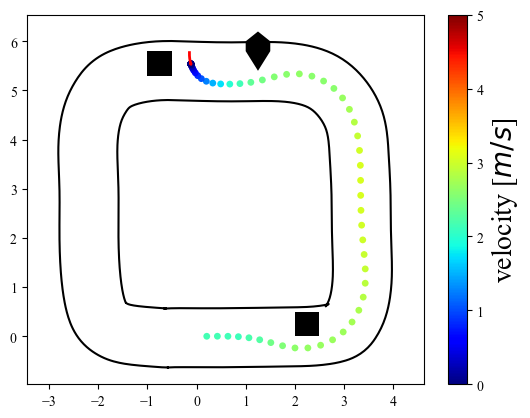

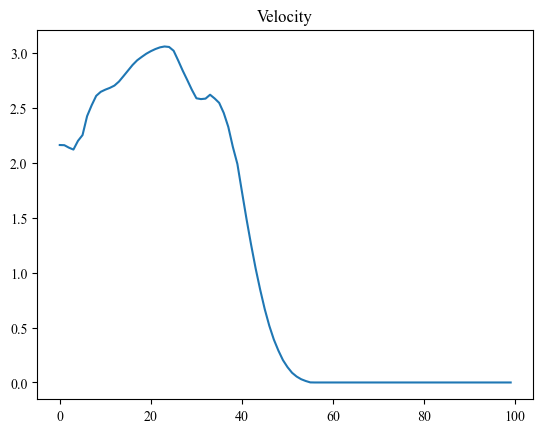

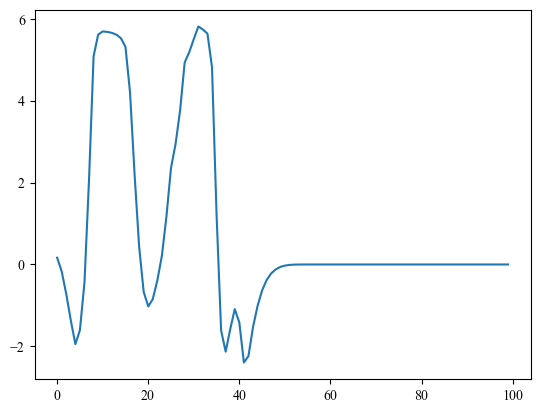

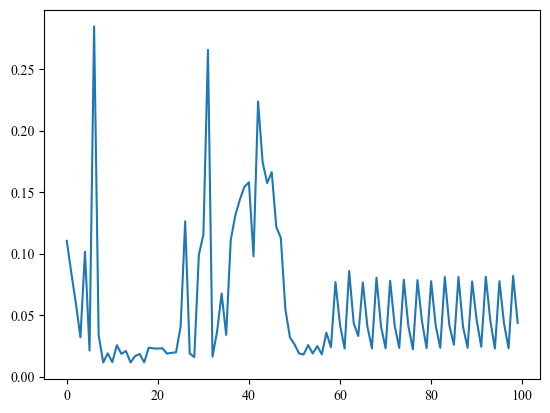

In [233]:
x_cur = np.array([0., 0., 2., 0., 0.])  # Initial state.

# Load ILQR
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)

config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR() #(config_file)
solver.update_path(path)

obs1 = np.array([[-1, -1, -0.5, -0.5], [5.3, 5.8, 5.8, 5.3]]).T
obs2 = np.array([[1, 1.25, 1.5, 1.5, 1.25, 1], [5.8, 5.4, 5.8 , 6.0, 6.2, 6.0]]).T
obs3 = np.array([[2.5, 2.5, 2, 2], [-0, 0.5, 0.5, -0]]).T
# obs4 = np.array([[-200, -200, -1.5, -1.5], [0.5, 1, 1, 0.5]]).T
obs_list = [[obs1 for _ in range(10)], 
            [obs2 for _ in range(10)],
            [obs3 for _ in range(10)]]
            # [obs4 for _ in range(10)]]
solver.update_obstacles(obs_list)

# define some parameters
n = 10
itr_receding = 100
init_control = np.zeros((2, n))
fig_prog_folder = 'fig/'

state_history = np.zeros((5,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    
    plan = solver.plan(x_cur, init_control)
    states = plan['states']
    controls = plan['controls']
    x_cur = states[:,1]
    state_history[:,i]  = x_cur
    init_control[:,:-1] = controls[:,1:]
    pbar.set_description(f"iLQR takes : {plan['t_process']:.2f} sec']")
    t_process[i] = plan['t_process']
    # plot
    plt.clf()
    path.plot_track()
    p = Polygon(obs1, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs2, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs3, facecolor = 'k')
    plt.gca().add_patch(p)

    # p = Polygon(obs4, facecolor = 'k')
    # plt.gca().add_patch(p)
    
    sc = plt.scatter(
        state_history[0, :i], state_history[1, :i], s=24,
        c=state_history[2, :i], cmap=cm.jet, vmin=0, vmax=5,
        edgecolor='none', marker='o'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(r"velocity [$m/s$]", size=20)
    
    plt.plot(states[0, :], states[1, :], 'r', linewidth=2)
    plt.axis('equal')
    plt.savefig(os.path.join(fig_prog_folder, str(i)+".png"), dpi=200)
plt.close('All')

gif_path = os.path.join(fig_prog_folder, 'rollout.gif')
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(itr_receding):
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)

plt.figure()
plt.plot(state_history[2,:])
plt.title('Velocity')


plt.figure()
a = state_history[2, :]**2 / 0.257 * np.tan(state_history[-1, :])
plt.plot(a)

plt.figure()
plt.plot(t_process)

